In [11]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import pickle

In [12]:
def Gaussian_pdf(mu, sigma, stds=4):
    x = np.linspace(mu - stds*sigma, mu + stds*sigma, 100)
    y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return x, y

def sigma_w_to_eta(sigma_w, V_th, tau_m, f):
    """Convert sigma_w to eta."""
    return (sigma_w * np.sqrt(tau_m)) / V_th

In [13]:
def approx_mi(means, variances):
    return np.log(np.mean(variances) + np.var(means)) - np.mean(np.log(variances))

def numerical_mi(means, variances, n_samples=int(1e4)):
    samples = []
    for mean, var in zip(means, variances):
        samples.extend(norm.rvs(loc=mean, scale=np.sqrt(var), size=n_samples))
    histogram, _ = np.histogram(samples, bins='auto', density=True)
    histogram = histogram + np.finfo(float).eps
    H_Y = -np.sum(histogram * np.log(histogram) * np.diff(np.linspace(np.min(samples), np.max(samples), len(histogram) + 1)))

    H_Y_given_X = np.mean([0.5 * np.log(2 * np.pi * np.e * var) for var in variances])

    return H_Y - H_Y_given_X

def get_R(mis, fs, tau_x, corr=True, norm=True):
    info_rate = mis * fs[np.newaxis, :]
    
    if corr:
        corr_fact_sampling = (1 - np.exp(-(1/(fs*tau_x))))
        info_rate = info_rate * corr_fact_sampling[np.newaxis, :]
    
    if norm:
        info_rate_norm = np.zeros_like(info_rate)  
        for index, row in enumerate(info_rate):
            info_rate_norm[index, :] = row/np.max(row)
        info_rate = info_rate_norm
        
    return info_rate

## Simulations

### Increased overlap between distributions at aronud 15 Hz happens because fixing I_osc and increasing freq leads to higher I_s, dominating over I_osc. Alternative approaches are: fixing v_osc_amp, or adjusting I_osc so that I_s range is constant. At the same time, changes in I_s and I_osc should add proportionally to the noise.

### Low-pass filtering properties of membrane justifies using a fixed I_osc. And then we can also test adjusted I_osc to equate v_osc_amp across freq range for the "ideal world".

## TO DO: estimate 'optimal' AHP peak and tau according to I_s (e.g., alpha) and freq., to solve previous-cycle spike interference issues.

In [26]:
# NEW - with AHP compensating for half of the cycle
def compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc):
    """Compute the expected phase of firing."""
    # Compute T and A
    T = 2 * np.pi / omega
    A = 1 / np.sqrt(1 + (tau_m * omega)**2)
    varphi = -np.arctan(omega * tau_m)
    
    # Compute the exponential terms
    exp_term1 = np.exp(-T / tau_m)
    exp_term2 = np.exp(-T / (2 * tau_m))
    exp_term3 = np.exp(-1 / 2)
    exp_term4 = np.exp(-1)
    
    # Compute the numerator terms
    numerator_1 = V_th * (1 - (exp_term4 - exp_term1) / (exp_term3 - exp_term2))
    numerator_2 = R_m * I_s * ((1 - exp_term1) + (1 - exp_term2) * (exp_term4 - exp_term1) / (exp_term3 - exp_term2))
    numerator_3 = R_m * I_osc * A * (1 - exp_term2) * (exp_term4 - exp_term1) / (exp_term3 - exp_term2)
    
    # Compute the total numerator
    numerator = numerator_1 + numerator_2 + numerator_3
    
    # Compute the denominator
    denominator = R_m * I_osc * A * (1 - exp_term1)
    
    # Compute the argument of arccos
    argument = numerator / denominator
    
    # Compute the phase
    phi = (np.pi - np.arccos(argument)) - varphi
    
    return phi


# NEW - with AHP compensating for half of the cycle
def get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac=.9):
    T = 2 * np.pi / omega
    A = 1 / np.sqrt(1 + (tau_m * omega)**2)
    
    # Compute the exponential terms
    exp_term1 = np.exp(-T / tau_m)
    exp_term2 = np.exp(-T / (2 * tau_m))
    exp_term3 = np.exp(-1 / 2)
    exp_term4 = np.exp(-1)
    
    # Compute the numerator terms
    numerator_1 = V_th * (1 - (exp_term4 - exp_term1) / (exp_term3 - exp_term2))
    numerator_2 = R_m * ((1 - exp_term1) + (1 - exp_term2) * (exp_term4 - exp_term1) / (exp_term3 - exp_term2))
    numerator_3 = R_m * I_osc * A * (1 - exp_term2) * (exp_term4 - exp_term1) / (exp_term3 - exp_term2)
    
    # Compute the denominator
    denominator = R_m * I_osc * A * (1 - exp_term1)
    
    Is_min = (-denominator - numerator_1 - numerator_3) / numerator_2
    Is_max = (denominator - numerator_1 - numerator_3) / numerator_2
    
    corr_frac = (1 - range_frac) * (Is_max - Is_min) / 2
    Is_min += corr_frac
    Is_max -= corr_frac
    
    return Is_min, Is_max

In [27]:
def simulate_neurons(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, M, dt, t, n_neurons, store_trajectories=False):
    alpha = I_s / I_s_ref
    sigma_W = eta * alpha * V_th / np.sqrt(tau_m)
    phi_0 = compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc)
    print(phi_0)
    
    T = 1 / f
    A = 1 / np.sqrt(1 + (tau_m * omega)**2)
    tau_AHP = T
    #amp_AHP = (R_m * (I_s + I_osc * A) * (1 - np.exp(-T / tau_m)) - V_th) / (R_m * (1 - np.exp(-T / tau_AHP)))
    num_AHP = -V_th + R_m * I_s * (1 - np.exp(-(T/2) / tau_m)) + R_m * I_osc * (1 - np.exp(-(T/2) / tau_m))
    denom_AHP = R_m * (tau_AHP / (tau_AHP - tau_m)) * (np.exp(-1) - np.exp(-tau_AHP / tau_m))
    amp_AHP = num_AHP / denom_AHP
    
    V = np.zeros(n_neurons)
    first_spike_phase = np.empty(n_neurons, dtype='object')
    first_spike_phase[:] = None
    first_spike_times = np.full(n_neurons, np.nan)
    has_spiked = np.zeros(n_neurons, dtype=bool)
    
    if store_trajectories:
        voltage_trajectories = np.zeros((len(t), n_neurons))
    
    for i in range(len(t)):
        xi = np.random.normal(0, 1/np.sqrt(dt), n_neurons)
        I_theta = I_osc * np.cos(omega * t[i] - np.pi + phi_0)
        I_AHP = -amp_AHP * np.exp(-t[i]/tau_AHP)
        dV_dt = (-V + R_m * (I_theta + I_s + I_AHP) + tau_m * sigma_W * xi) / tau_m
        V += dV_dt * dt
        
        if store_trajectories:
            voltage_trajectories[i, :] = V
        
        spiked = V >= V_th
        if np.any(spiked):
            V[spiked] = 0 
            if (omega * t[i] - np.pi + phi_0) > np.pi:
                mask = spiked & (first_spike_phase == None)
                first_spike_phase[mask] = (omega * t[i] + phi_0) % (2 * np.pi)
                first_spike_times[mask] = t[i]
                if np.all(first_spike_phase != None):
                    break
    
    if store_trajectories:
        return first_spike_phase, voltage_trajectories, first_spike_times, phi_0
    else:
        return first_spike_phase


def get_distr_empirical(R_m, V_th, eta, tau_m, I_osc, f, M, dt, t, num_trials, range_frac, store_trajectories=False):
    omega = 2 * np.pi * f
    I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac=range_frac)
    Is_range = np.linspace(I_min, I_max, M)
    print(Is_range)
    
    means = []
    variances = []
    all_first_spike_phases = []
    all_voltages = []
    all_first_spike_times = []
    all_phi_0 = []
    
    for I_s in Is_range:
        if store_trajectories:
            first_spike_phases, voltage_trajectories, first_spike_times, phi_0 = simulate_neurons(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, M, dt, t, num_trials, store_trajectories)
            all_voltages.append(voltage_trajectories)
            all_first_spike_times.append(first_spike_times)
            all_phi_0.append(phi_0)
        else:
            first_spike_phases = simulate_neurons(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, M, dt, t, num_trials)
        
        first_spike_phases = np.where(first_spike_phases == None, np.nan, first_spike_phases)
        all_first_spike_phases.append(first_spike_phases)
        means.append(np.nanmean(first_spike_phases))
        variances.append(np.nanvar(first_spike_phases))
    
    if store_trajectories:
        return np.array(means), np.array(variances), all_first_spike_phases, Is_range, all_voltages, all_first_spike_times, all_phi_0
    else:
        return np.array(means), np.array(variances), all_first_spike_phases, Is_range

In [28]:
# Default params
R_m = 142 * 1e6  # 142 MΩ
V_th = 15 * 1e-3  # 15 mV
tau_m = 24 * 1e-3  # 24 ms
f = 5  # 5 Hz
omega = 2 * np.pi * f  # 5 Hz in rad/s
I_osc = 40 * 1e-12  # 40 pA
M = 5  # number of input levels
range_frac = 0.75  # fraction of range to use
sigma_w_avg = (0.012 + 0.015) / 2  # average sigma_w
eta = sigma_w_to_eta(sigma_w_avg, V_th, tau_m, f)  # Calculate eta
A_ahp = 0 * 1e-12

I_s_ref, _ = get_automatic_range(R_m, V_th, tau_m, 2*np.pi*1, I_osc, range_frac)

In [29]:
# Params
f = 10.                 # Hz
eta = 0.000005 #0.11             # a.u.

# Simulation parameters
dt = 1e-4              # Time step for numerical integration
t_end = 2 / f          # Duration of one cycle
t = np.arange(0, t_end, dt)
num_trials = 5000      # Number of trials


# Run the simulation and store voltage trajectories
means, variances, all_phis, Is_range, all_voltages, all_first_spike_times, all_phi_0 = get_distr_empirical(R_m, V_th, eta, tau_m, I_osc, f, M, dt, t, num_trials, range_frac, store_trajectories=True)

[-3.62461194e-11 -3.12221739e-11 -2.61982283e-11 -2.11742828e-11
 -1.61503373e-11]
1.7079695982861058


C:\Users\Afernandez\AppData\Local\Temp\ipykernel_30664\1508392666.py:74: RuntimeWarning: Mean of empty slice
  means.append(np.nanmean(first_spike_phases))


ZeroDivisionError: division by zero

In [18]:
def roll_with_nan(arr, shift):
    result = np.full_like(arr, np.nan)
    if shift > 0:
        result[shift:] = arr[:-shift]
    elif shift < 0:
        result[:shift] = arr[-shift:]
    else:
        result = arr
    return result

NameError: name 'all_phis' is not defined

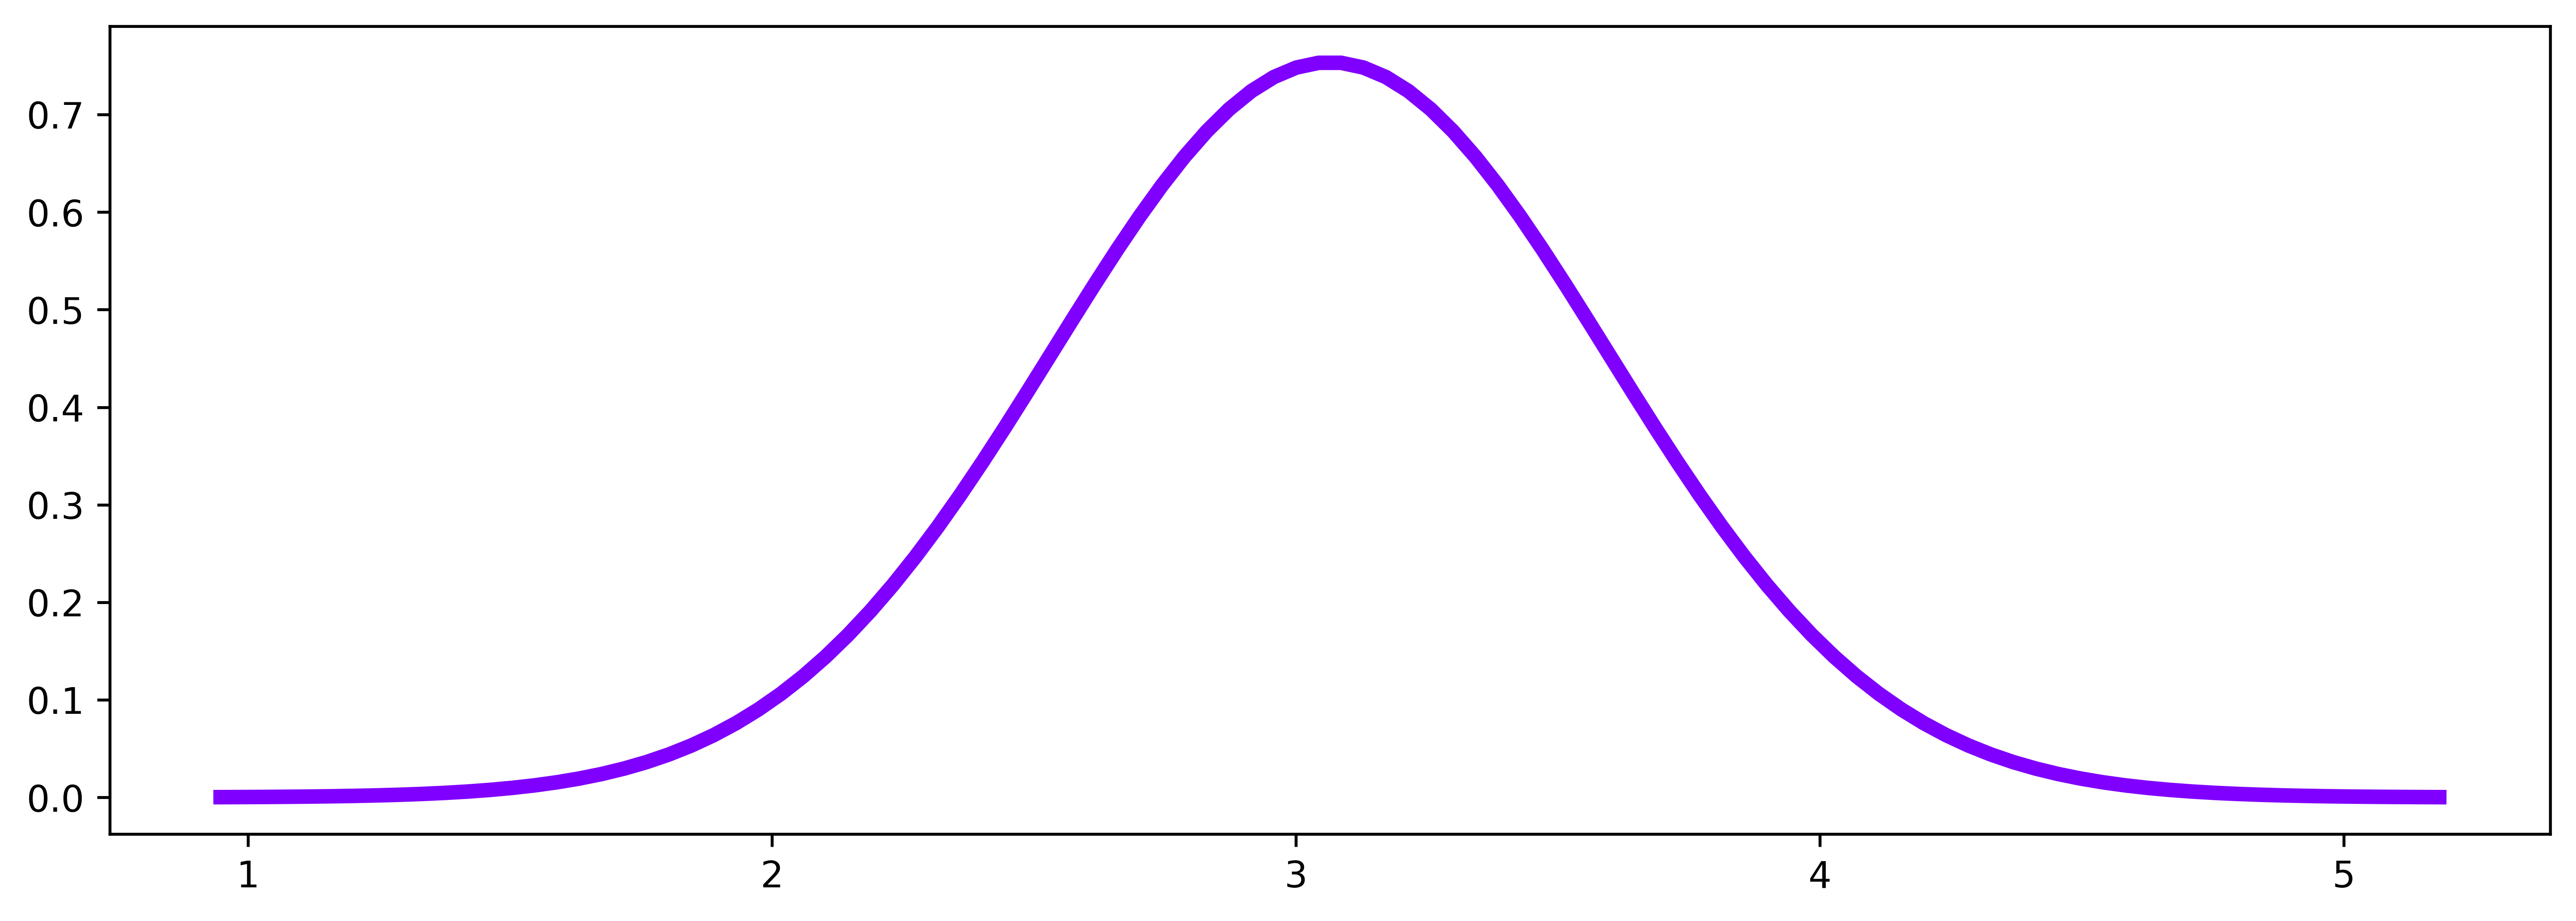

In [19]:
# Plotting the results
plt.figure(figsize=(12, 4), dpi=600)

alphas = np.linspace(0.2, 1, M)
c = cm.rainbow(np.linspace(0, 1, M))

for i, Is in enumerate(Is_range):
    x, y = Gaussian_pdf(means[i], np.sqrt(variances[i]))
    plt.plot(x, y, linewidth=4, linestyle='-', color=c[i], label=str(int(Is*1e12))+" pA")
    plt.hist(all_phis[i], bins='auto', density=True, color=c[i], alpha=.4)

plt.legend(frameon=False, fontsize=14)
plt.ylabel('p.d.f. (a.u.)', fontsize=18)
plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=18)
plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=16)
plt.xlim(-np.pi/2, (5/2)*np.pi)
plt.ylim(0, 5)
plt.yticks(fontsize=16)

plt.axvline(0, linestyle='--', color='k')
plt.axvline(2 * np.pi, linestyle='--', color='k')

sb.despine()
plt.tight_layout()
plt.show()

# Plot voltage trajectories with respect to oscillation I_theta
plt.figure(figsize=(10, 6))
for i, (voltage_trajectory, first_spike_times, phi_0) in enumerate(zip(all_voltages, all_first_spike_times, all_phi_0)):
    neuron_index = 1  # Choosing the first neuron as an example
    #t_temp = np.roll(t, -int(phi_0/(2*np.pi*f)/dt))
    shift = -int(phi_0 / (2 * np.pi * f) / dt)
    t_temp = roll_with_nan(t, shift)
    plt.plot(t_temp, voltage_trajectory[:, neuron_index], label=f'I_s = {Is_range[i]*1e12:.1f} pA', color=c[i], alpha=1)
    plt.plot(t, I_osc * np.cos(2 * np.pi * f * t - np.pi) * 1e8 - 0.005, '-', color='k', alpha=0.6)
    spike_time = first_spike_times[neuron_index] + phi_0/(2*np.pi*f)
    if not np.isnan(spike_time):
        plt.axvline(spike_time, color=c[i], linestyle='--', linewidth=2, alpha=1)

plt.axhline(V_th, color='k', linestyle='--', alpha=1)

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Membrane Potential (V)', fontsize=14)
plt.legend(loc='upper left')
plt.title('Voltage Trajectories of the First Neuron with Oscillatory Input', fontsize=16)
plt.show()

### At low frequencies (1-5 Hz) the difference between I_s levels is big enough so that voltage reset due to previous-cycle spikes do not interfere with phase relationships. However, at intermediate frequencies (10-20 Hz), we still have some previous-cycle spikes but with lower difference between I_s, and therefore, the previous-cycle spike reset induces important delays in phase, making the Gaussians overlap. Therefore, what we see if previous-cycle spike interference.

### Moreover, we see reduction of variance in strong inputs due to hard phase cutoff at 0.